https://www.tensorflow.org/tutorials/audio/transfer_learning_audio

In [1]:
import os
from IPython import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_hub as hub

In [2]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [4]:
testing_wav_file_name = tf.keras.utils.get_file(
    'miaow_16k.wav',
    'https://storage.googleapis.com/audioset/miaow_16k.wav',
    cache_dir='data',
    cache_subdir='test_data'
)

print(testing_wav_file_name)

215546/215546 [==============================] - 0s 1us/step
data\test_data\miaow_16k.wav


In [5]:
# Utility function for loading audio files and making sure the sample rate is correct
@tf.function
def load_wav_16k_mono(filename):
    '''
    Load a WAV file, convert it to float tensor, resample to 16 kHz single-channel audio.
    '''

    file_contents = tf.io.read_file(filename)

    wav, sample_rate = tf.audio.decode_wav(
        file_contents,
        desired_channels=1
    )

    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

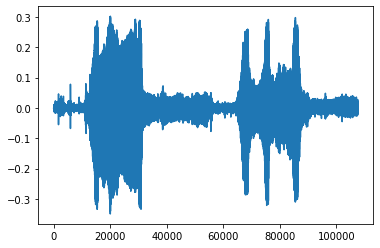

In [6]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file
display.Audio(testing_wav_data, rate=16000)

In [7]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names = list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
    print(name)

print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


In [8]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The emebdding shape is: {embeddings.shape}')

The main sound is: Animal
The emebdding shape is: (13, 1024)


In [12]:
_ = tf.keras.utils.get_file(
    'esc-50.zip',
    'https://github.com/karoldvl/ESC-50/archive/master.zip',
    cache_dir='data',
    cache_subdir='datasets',
    extract=True
)

645694376/645694376 [==============================] - 31s 0us/step


In [13]:
esc50_csv = 'data/datasets/ESC-50-master/meta/esc50.csv'
base_data_path = 'data/datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

In [14]:
my_classes = ['dog', 'cat']
map_classes_to_id = {'dog': 0, 'cat': 1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_classes_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

filename  fold  target category  \
0    data/datasets/ESC-50-master/audio/1-100032-A-0...     1       0      dog   
14   data/datasets/ESC-50-master/audio/1-110389-A-0...     1       0      dog   
157  data/datasets/ESC-50-master/audio/1-30226-A-0.wav     1       0      dog   
158  data/datasets/ESC-50-master/audio/1-30344-A-0.wav     1       0      dog   
170  data/datasets/ESC-50-master/audio/1-32318-A-0.wav     1       0      dog   
175  data/datasets/ESC-50-master/audio/1-34094-A-5.wav     1       1      cat   
176  data/datasets/ESC-50-master/audio/1-34094-B-5.wav     1       1      cat   
229  data/datasets/ESC-50-master/audio/1-47819-A-5.wav     1       1      cat   
230  data/datasets/ESC-50-master/audio/1-47819-B-5.wav     1       1      cat   
231  data/datasets/ESC-50-master/audio/1-47819-C-5.wav     1       1      cat   

     esc10  src_file take  
0     True    100032    A  
14    True    110389    A  
157   True     30226    A  
158   True     30344    A  
170   True     32318    A  
175  False     34094    A  
176  False     34094    B  
229  False     47819    A  
230  False     47819    B  
231  False     47819    C

In [15]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [16]:
def load_wav_for_map(filename, label, fold):
    return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [18]:
# Applies the mebedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
    '''Run YAMNet to extract embedding from the wav data.'''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]

    return (
        embeddings,
        tf.repeat(label, num_embeddings),
        tf.repeat(fold, num_embeddings)
    )

# Extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [19]:
cached_ds = main_ds.cache()

train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# Remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [20]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(
        shape=(1024),
        dtype=tf.float32,
        name='input_embedding'
    ),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
],
name='my_model'
)

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [21]:
my_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True
)

In [22]:
history = my_model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=callback
)

Epoch 1/20
15/15 [==============================] - 7s 121ms/step - loss: 1.1157 - accuracy: 0.8375 - val_loss: 0.3039 - val_accuracy: 0.8562
Epoch 2/20
15/15 [==============================] - 0s 7ms/step - loss: 0.4888 - accuracy: 0.8813 - val_loss: 0.2262 - val_accuracy: 0.9125
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 0.3831 - accuracy: 0.8687 - val_loss: 0.2082 - val_accuracy: 0.9187
Epoch 4/20
15/15 [==============================] - 0s 7ms/step - loss: 0.2811 - accuracy: 0.8938 - val_loss: 0.2753 - val_accuracy: 0.8687
Epoch 5/20
15/15 [==============================] - 0s 7ms/step - loss: 0.3180 - accuracy: 0.8938 - val_loss: 0.5120 - val_accuracy: 0.8750
Epoch 6/20
15/15 [==============================] - 0s 8ms/step - loss: 0.1872 - accuracy: 0.9250 - val_loss: 0.2469 - val_accuracy: 0.8750
Epoch 7/20
15/15 [==============================] - 0s 7ms/step - loss: 0.2436 - accuracy: 0.9167 - val_loss: 0.2342 - val_accuracy: 0.8750
Epoch 8/20
15/15 [

In [23]:
loss, accuracy = my_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

5/5 [==============================] - 0s 10ms/step - loss: 0.3153 - accuracy: 0.8313
Loss: 0.31534141302108765
Accuracy: 0.831250011920929


In [24]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()
inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: cat


In [25]:
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, input):
        return tf.math.reduce_mean(input, axis=self.axis)

In [26]:
saved_model_path = 'models/dogs_and_cats_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')

embedding_extraction_layer = hub.KerasLayer(
    yamnet_model_handle,
    trainable=False,
    name='yamnet'
)

_, embeddings_output, _ = embedding_extraction_layer(input_segment)

serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)

serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: models/dogs_and_cats_yamnet\assets


INFO:tensorflow:Assets written to: models/dogs_and_cats_yamnet\assets


In [27]:
tf.keras.utils.plot_model(serving_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [28]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [30]:
reloaded_results = reloaded_model(testing_wav_data)
cat_or_dog = my_classes[tf.argmax(reloaded_results)]
print(f'The main sound is: {cat_or_dog}')

The main sound is: cat


In [31]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
cat_or_dog = my_classes[tf.argmax(serving_results['classifier'])]
print(f'The main sound is: {cat_or_dog}')

The main sound is: cat


data/datasets/ESC-50-master/audio/5-231762-A-0.wav


Waveform values: [ 0.0000000e+00  3.3992906e-10 -3.0525005e-10 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]


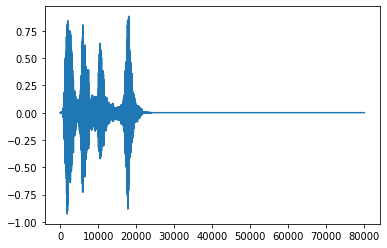

In [32]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 5]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)

waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')

_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [33]:
# Run the model, check the output
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
inferred_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {inferred_class} ({top_score})')

reloaded_results = reloaded_model(waveform)
your_top_classs = tf.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_classs]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_classs]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')

[YAMNet] The main sound is: Silence (0.7000001668930054)
[Your model] The main sound is: dog (0.9756128191947937)
